# ANN Model training and testing 

In [1]:
from gwsnr import GWSNR
gwsnr = GWSNR(snr_type='ann', waveform_approximant='IMRPhenomXPHM', pdet=True)

psds not given. Choosing bilby's default psds
npool:  4
snr type:  ann
waveform approximant:  IMRPhenomXPHM
sampling frequency:  2048.0
minimum frequency (fmin):  20.0
mtot=mass1+mass2
min(mtot):  2.0
max(mtot) (with the given fmin=20.0): 184.98599853446768
detectors:  None
ANN method is selected.
Please be patient while the interpolator is generated of partialscaledSNR for IMRPhenomD.
Interpolator will be loaded for L1 detector from ./interpolator_pickle/L1/halfSNR_dict_1.pickle
Interpolator will be loaded for H1 detector from ./interpolator_pickle/H1/halfSNR_dict_1.pickle
Interpolator will be loaded for V1 detector from ./interpolator_pickle/V1/halfSNR_dict_1.pickle


In [2]:
import numpy as np
mass_1 = np.array([5, 10.,50.,200.])
ratio = np.array([1, 0.8,0.5,0.2])
luminosity_distance = np.array([1000, 2000, 3000, 4000])
# gwsnr.snr_with_ann(mass_1=mass_1, mass_2=mass_1*ratio, luminosity_distance=luminosity_distance)
gwsnr.snr(mass_1=mass_1, mass_2=mass_1*ratio, luminosity_distance=luminosity_distance)

1/1 [==============================] - 0s 26ms/step


{'pdet_L1': array([0, 0, 1, 0]),
 'pdet_H1': array([0, 0, 0, 0]),
 'pdet_V1': array([0, 0, 0, 0]),
 'pdet_net': array([1, 0, 1, 0])}

In [3]:
snr_bilby = gwsnr.compute_bilby_snr(mass_1=mass_1, mass_2=mass_1*ratio, luminosity_distance=luminosity_distance)
gwsnr.probability_of_detection(snr_dict=snr_bilby, type='bool')

100%|█████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.19s/it]


{'pdet_L1': array([0, 0, 1, 0]),
 'pdet_H1': array([0, 0, 0, 0]),
 'pdet_V1': array([0, 0, 0, 0]),
 'pdet_net': array([1, 0, 1, 0])}

## Data preprocessing

In [5]:
import numpy as np
import pandas as pd
import tensorflow as tf

In [6]:
# get data
from ler.utils import append_json, load_json
import numpy as np
unlensed_params = load_json("jointnewL1.json")
# for key, value in unlensed_params.items():
#     unlensed_params[key] = np.array(value)
# randomize the data
idx_shuffle = np.random.permutation(len(unlensed_params['L1']))
for key, value in unlensed_params.items():
    unlensed_params[key] = np.array(value)[idx_shuffle]
#snr = np.array(unlensed_params['L1'])

In [7]:
# let's generate IMRPhenomD (spinless) interpolartor
from gwsnr import GWSNR
gwsnr = GWSNR(snr_type='ann', waveform_approximant='IMRPhenomXPHM')

psds not given. Choosing bilby's default psds
npool:  4
snr type:  ann
waveform approximant:  IMRPhenomXPHM
sampling frequency:  2048.0
minimum frequency (fmin):  20.0
mtot=mass1+mass2
min(mtot):  2.0
max(mtot) (with the given fmin=20.0): 184.98599853446768
detectors:  None
ANN method is selected.
Please be patient while the interpolator is generated of partialscaledSNR for IMRPhenomD.
Interpolator will be loaded for L1 detector from ./interpolator_pickle/L1/halfSNR_dict_1.pickle
Interpolator will be loaded for H1 detector from ./interpolator_pickle/H1/halfSNR_dict_1.pickle
Interpolator will be loaded for V1 detector from ./interpolator_pickle/V1/halfSNR_dict_1.pickle


In [8]:
from gwsnr import antenna_response_array, cubic_spline_interpolator2d

def input_output(idx, params):

    mass_1 = np.array(params['mass_1'])[idx]
    mass_2 = np.array(params['mass_2'])[idx]
    luminosity_distance = np.array(params['luminosity_distance'])[idx]
    theta_jn = np.array(params['theta_jn'])[idx]
    psi = np.array(params['psi'])[idx]
    geocent_time = np.array(params['geocent_time'])[idx]
    ra = np.array(params['ra'])[idx]
    dec = np.array(params['dec'])[idx]
    
    detector_tensor = gwsnr.detector_tensor_list
    snr_halfscaled = np.array(gwsnr.snr_partialsacaled_list)
    ratio_arr = gwsnr.ratio_arr
    mtot_arr = gwsnr.mtot_arr
    
    size = len(mass_1)
    len_ = len(detector_tensor)
    mtot = mass_1 + mass_2
    ratio = mass_2 / mass_1
    # get array of antenna response
    Fp, Fc = antenna_response_array(ra, dec, geocent_time, psi, detector_tensor)

    Mc = ((mass_1 * mass_2) ** (3 / 5)) / ((mass_1 + mass_2) ** (1 / 5))
    eta = mass_1 * mass_2/(mass_1 + mass_2)**2.
    A1 = Mc ** (5.0 / 6.0)
    ci_2 = np.cos(theta_jn) ** 2
    ci_param = ((1 + np.cos(theta_jn) ** 2) / 2) ** 2
    
    size = len(mass_1)
    snr_half_ = np.zeros((len_,size))
    d_eff = np.zeros((len_,size))

    # loop over the detectors
    for j in range(len_):
        # loop over the parameter points
        for i in range(size):
            snr_half_coeff = snr_halfscaled[j]
            snr_half_[j,i] = cubic_spline_interpolator2d(mtot[i], ratio[i], snr_half_coeff, mtot_arr, ratio_arr)
            d_eff[j,i] =luminosity_distance[i] / np.sqrt(
                    Fp[j,i]**2 * ci_param[i] + Fc[j,i]**2 * ci_2[i]
                )

    #amp0
    amp0 =  A1 / d_eff

    # get spin parameters
    a_1 = np.array(params['a_1'])[idx]
    a_2 = np.array(params['a_2'])[idx]
    tilt_1 = np.array(params['tilt_1'])[idx]
    tilt_2 = np.array(params['tilt_2'])[idx]
    phi_12 = np.array(params['phi_12'])[idx]
    phi_jl = np.array(params['phi_jl'])[idx]

    # input data
    # X = np.vstack([L1, amp0, Mc, eta, theta_jn, a_1, a_2, tilt_1, tilt_2, phi_12, phi_jl]).T
    XL1 = np.vstack([snr_half_[0], amp0[0], eta, a_1, a_2, tilt_1, tilt_2, phi_12, phi_jl]).T
    XH1 = np.vstack([snr_half_[1], amp0[1], eta, a_1, a_2, tilt_1, tilt_2, phi_12, phi_jl]).T
    XV1 = np.vstack([snr_half_[2], amp0[2], eta, a_1, a_2, tilt_1, tilt_2, phi_12, phi_jl]).T

    # output data
    # get L1 snr for y train 
    yL1 = params['L1'][idx]
    yH1 = params['H1'][idx]
    yV1 = params['V1'][idx]


    return(XL1, XH1, XV1, yL1, yH1, yV1)

In [9]:
len_ = len(unlensed_params['L1'])
idx = np.arange(len_)
# randomize the train set
idx = np.random.permutation(idx)
XL1, XH1, XV1, yL1, yH1, yV1 = input_output(idx, unlensed_params)
np.shape(XL1)

(77240, 9)

In [10]:
# import matplotlib.pyplot as plt
# plt.hist(y[y<100], bins=100)
# plt.xlim(0,20)
# plt.show()

## Now back to ANN

### L1

In [4]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(XL1, yL1, test_size = 0.1, random_state = 0)


NameError: name 'XL1' is not defined

In [10]:
# print(np.shape(X_train))
# print(np.shape(X_test))

In [11]:
# feature scaling
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [12]:
# save the scaler
import pickle
pickle.dump(sc, open('scalerL1.pkl', 'wb'))

In [15]:
# initialize the ANN
ann = tf.keras.models.Sequential() 

# adding the input layer and the first hidden layer
ann.add(tf.keras.layers.Dense(units=9, activation='relu'))
# adding the second hidden layer
ann.add(tf.keras.layers.Dense(units=32, activation='relu'))
# adding the third hidden layer
ann.add(tf.keras.layers.Dense(units=32, activation='sigmoid'))
# adding the output layer, absolute value of the snr
ann.add(tf.keras.layers.Dense(units=1, activation='linear'))
#ann.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))

In [16]:
# compile the ANN
ann.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics = ['accuracy'])

In [17]:
# train the ANN on the training set
ann.fit(X_train, y_train, batch_size = 32, epochs = 200, workers=4, use_multiprocessing=True)

Epoch 1/200
2173/2173 [==============================] - 2s 519us/step - loss: 2461.3589 - accuracy: 0.0012
Epoch 2/200
2173/2173 [==============================] - 1s 488us/step - loss: 2432.8850 - accuracy: 0.0016
Epoch 3/200
2173/2173 [==============================] - 1s 515us/step - loss: 2427.8108 - accuracy: 0.0031
Epoch 4/200
2173/2173 [==============================] - 1s 508us/step - loss: 2424.9954 - accuracy: 0.0033
Epoch 5/200
2173/2173 [==============================] - 1s 484us/step - loss: 2422.7844 - accuracy: 0.0036
Epoch 6/200
2173/2173 [==============================] - 1s 510us/step - loss: 2420.0942 - accuracy: 0.0038
Epoch 7/200
2173/2173 [==============================] - 1s 506us/step - loss: 2418.3049 - accuracy: 0.0039
Epoch 8/200
2173/2173 [==============================] - 1s 485us/step - loss: 2416.9607 - accuracy: 0.0038
Epoch 9/200
2173/2173 [==============================] - 1s 507us/step - loss: 2415.7354 - accuracy: 0.0041
Epoch 10/200
2173/2173 [====

In [18]:
y_pred = ann.predict(X_test)
#y_pred = (y_pred > 0.5)
print(np.concatenate((y_pred.reshape(len(y_pred),1), y_test.reshape(len(y_test),1)),1)[10:20])

242/242 [==============================] - 0s 289us/step
[[ 6.31955719  6.19221387]
 [ 7.10153484  7.52039616]
 [15.48692894 15.45474127]
 [ 3.82799244  3.78724652]
 [19.17204475 20.14008867]
 [ 3.09477806  3.13593516]
 [18.55880928 19.75293004]
 [ 6.14690828  6.19711101]
 [11.20474815 10.09325226]
 [ 2.21424007  2.38535518]]


In [19]:
len1 = len(y_pred)
len2 = np.sum((y_pred.flatten()>8) != (y_test>8))
error = len2/len1*100
print(f"Error: {error:.2f}%")

Error: 2.43%


In [20]:
# Save the model to a file
ann.save('ann_modelL1.h5')

### H1

In [21]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(XH1, yH1, test_size = 0.1, random_state = 0)

# feature scaling
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

# save the scaler
import pickle
pickle.dump(sc, open('scalerH1.pkl', 'wb'))

In [22]:
# initialize the ANN
ann = tf.keras.models.Sequential() 

# adding the input layer and the first hidden layer
ann.add(tf.keras.layers.Dense(units=9, activation='relu'))
# adding the second hidden layer
ann.add(tf.keras.layers.Dense(units=32, activation='relu'))
# adding the third hidden layer
ann.add(tf.keras.layers.Dense(units=32, activation='sigmoid'))
# adding the output layer, absolute value of the snr
ann.add(tf.keras.layers.Dense(units=1, activation='linear'))
#ann.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))

In [23]:
# compile the ANN
# loss = 'mean_squared_error'
ann.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics = ['accuracy'])

In [24]:
# train the ANN on the training set
ann.fit(X_train, y_train, batch_size = 32, epochs = 200, workers=4, use_multiprocessing=True)

Epoch 1/200


2173/2173 [==============================] - 1s 508us/step - loss: 1512.3213 - accuracy: 0.0013
Epoch 2/200
2173/2173 [==============================] - 1s 535us/step - loss: 1488.0007 - accuracy: 0.0019
Epoch 3/200
2173/2173 [==============================] - 1s 533us/step - loss: 1480.9833 - accuracy: 0.0031
Epoch 4/200
2173/2173 [==============================] - 1s 500us/step - loss: 1477.4314 - accuracy: 0.0039
Epoch 5/200
2173/2173 [==============================] - 1s 534us/step - loss: 1475.5961 - accuracy: 0.0040
Epoch 6/200
2173/2173 [==============================] - 1s 497us/step - loss: 1473.2994 - accuracy: 0.0039
Epoch 7/200
2173/2173 [==============================] - 1s 553us/step - loss: 1471.6851 - accuracy: 0.0038
Epoch 8/200
2173/2173 [==============================] - 1s 625us/step - loss: 1470.0814 - accuracy: 0.0039
Epoch 9/200
2173/2173 [==============================] - 1s 505us/step - loss: 1468.9038 - accuracy: 0.0041
Epoch 10/200
2173/2173 [================

In [25]:
y_pred = ann.predict(X_test)
#y_pred = (y_pred > 0.5)
print(np.concatenate((y_pred.reshape(len(y_pred),1), y_test.reshape(len(y_test),1)),1)[10:20])

242/242 [==============================] - 0s 285us/step
[[ 5.64273834  5.46883377]
 [10.9793005  10.70129808]
 [15.69080448 15.4378586 ]
 [ 3.41800499  3.47881364]
 [24.89271927 25.88531327]
 [ 2.58902168  2.74633207]
 [17.99505997 18.71973532]
 [ 5.50210953  5.63567116]
 [13.02195454 11.7723755 ]
 [ 1.86098099  2.33553513]]


In [26]:
len1 = len(y_pred)
len2 = np.sum((y_pred.flatten()>8) != (y_test>8))
error = len2/len1*100
print(f"Error: {error:.2f}%")

Error: 2.73%


In [27]:
# Save the model to a file
ann.save('ann_modelH1.h5')

### V1

In [28]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(XV1, yV1, test_size = 0.1, random_state = 0)

# feature scaling
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

# save the scaler
import pickle
pickle.dump(sc, open('scalerV1.pkl', 'wb'))

In [29]:
# initialize the ANN
ann = tf.keras.models.Sequential() 

# adding the input layer and the first hidden layer
ann.add(tf.keras.layers.Dense(units=9, activation='relu'))
# adding the second hidden layer
ann.add(tf.keras.layers.Dense(units=32, activation='relu'))
# adding the third hidden layer
ann.add(tf.keras.layers.Dense(units=32, activation='sigmoid'))
# adding the output layer, absolute value of the snr
ann.add(tf.keras.layers.Dense(units=1, activation='linear'))
#ann.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))

In [30]:
# compile the ANN
# loss = 'mean_squared_error'
ann.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics = ['accuracy'])

In [31]:
# train the ANN on the training set
ann.fit(X_train, y_train, batch_size = 32, epochs = 200, workers=4, use_multiprocessing=True)

Epoch 1/200


2173/2173 [==============================] - 1s 500us/step - loss: 753.1311 - accuracy: 0.0029
Epoch 2/200
2173/2173 [==============================] - 1s 521us/step - loss: 742.8470 - accuracy: 0.0037
Epoch 3/200
2173/2173 [==============================] - 1s 535us/step - loss: 740.0916 - accuracy: 0.0046
Epoch 4/200
2173/2173 [==============================] - 1s 506us/step - loss: 738.0026 - accuracy: 0.0049
Epoch 5/200
2173/2173 [==============================] - 1s 527us/step - loss: 736.1973 - accuracy: 0.0052
Epoch 6/200
2173/2173 [==============================] - 1s 528us/step - loss: 735.0300 - accuracy: 0.0053
Epoch 7/200
2173/2173 [==============================] - 1s 476us/step - loss: 733.9265 - accuracy: 0.0053
Epoch 8/200
2173/2173 [==============================] - 1s 512us/step - loss: 732.8179 - accuracy: 0.0054
Epoch 9/200
2173/2173 [==============================] - 1s 520us/step - loss: 731.8058 - accuracy: 0.0054
Epoch 10/200
2173/2173 [=========================

In [32]:
y_pred = ann.predict(X_test)
#y_pred = (y_pred > 0.5)
print(np.concatenate((y_pred.reshape(len(y_pred),1), y_test.reshape(len(y_test),1)),1)[10:20])

242/242 [==============================] - 0s 289us/step
[[ 4.70164871  4.60294629]
 [ 7.08188534  7.20077038]
 [ 9.95392418  9.69107048]
 [ 1.41868019  1.464477  ]
 [19.21713829 18.97517837]
 [ 1.91390228  2.08792123]
 [20.99995422 21.31686381]
 [ 7.28342438  7.24676503]
 [12.31026649  9.60957984]
 [ 0.60850334  0.76886953]]


In [33]:
len1 = len(y_pred)
len2 = np.sum((y_pred.flatten()>8) != (y_test>8))
error = len2/len1*100
print(f"Error: {error:.2f}%")

Error: 1.40%


In [34]:
# Save the model to a file
ann.save('ann_modelV1.h5')

## Load all models and test them

In [13]:
from tensorflow.keras.models import load_model
modelL1 = load_model('ann_modelL1.h5')
modelH1 = load_model('ann_modelH1.h5')
modelV1 = load_model('ann_modelV1.h5')

# load the scaler
import pickle
scalerL1 = pickle.load(open('scalerL1.pkl', 'rb'))
scalerH1 = pickle.load(open('scalerH1.pkl', 'rb'))
scalerV1 = pickle.load(open('scalerV1.pkl', 'rb'))

In [14]:
def input_output_net(idx, params):

    mass_1 = np.array(params['mass_1'][idx])
    mass_2 = np.array(params['mass_2'][idx])
    luminosity_distance = np.array(params['luminosity_distance'][idx])
    theta_jn = np.array(params['theta_jn'][idx])
    psi = np.array(params['psi'][idx])
    geocent_time = np.array(params['geocent_time'][idx])
    ra = np.array(params['ra'][idx])
    dec = np.array(params['dec'][idx])
    
    detector_tensor = gwsnr.detector_tensor_list
    snr_halfscaled = np.array(gwsnr.snr_partialsacaled_list)
    ratio_arr = gwsnr.ratio_arr
    mtot_arr = gwsnr.mtot_arr
    
    size = len(mass_1)
    len_ = len(detector_tensor)
    mtot = mass_1 + mass_2
    ratio = mass_2 / mass_1
    # get array of antenna response
    Fp, Fc = antenna_response_array(ra, dec, geocent_time, psi, detector_tensor)

    Mc = ((mass_1 * mass_2) ** (3 / 5)) / ((mass_1 + mass_2) ** (1 / 5))
    eta = mass_1 * mass_2/(mass_1 + mass_2)**2.
    A1 = Mc ** (5.0 / 6.0)
    ci_2 = np.cos(theta_jn) ** 2
    ci_param = ((1 + np.cos(theta_jn) ** 2) / 2) ** 2
    
    size = len(mass_1)
    snr_half_ = np.zeros((len_,size))
    d_eff = np.zeros((len_,size))

    # loop over the detectors
    for j in range(len_):
        # loop over the parameter points
        for i in range(size):
            snr_half_coeff = snr_halfscaled[j]
            snr_half_[j,i] = cubic_spline_interpolator2d(mtot[i], ratio[i], snr_half_coeff, mtot_arr, ratio_arr)
            d_eff[j,i] =luminosity_distance[i] / np.sqrt(
                    Fp[j,i]**2 * ci_param[i] + Fc[j,i]**2 * ci_2[i]
                )

    #amp0
    amp0 =  A1 / d_eff

    # get spin parameters
    a_1 = np.array(params['a_1'][idx])
    a_2 = np.array(params['a_2'][idx])
    tilt_1 = np.array(params['tilt_1'][idx])
    tilt_2 = np.array(params['tilt_2'][idx])
    phi_12 = np.array(params['phi_12'][idx])
    phi_jl = np.array(params['phi_jl'][idx])

    # input data
    L1 = np.vstack([snr_half_[0], amp0[0], eta, a_1, a_2, tilt_1, tilt_2, phi_12, phi_jl]).T
    H1 = np.vstack([snr_half_[1], amp0[1], eta, a_1, a_2, tilt_1, tilt_2, phi_12, phi_jl]).T
    V1 = np.vstack([snr_half_[2], amp0[2], eta, a_1, a_2, tilt_1, tilt_2, phi_12, phi_jl]).T

    X = np.array([L1, H1, V1])

    # output data
    # get L1 snr for y train 
    y = np.sqrt(params['L1'][idx]**2 + params['H1'][idx]**2 + params['V1'][idx]**2)

    return(X,y)

In [15]:
X_, Y_ = input_output_net(np.array([1000,1001,1002]), unlensed_params)

In [16]:
def input_output_netANN(x_array):
    x = scalerL1.transform(x_array[0])
    yL1 = modelL1.predict(x)
    x = scalerH1.transform(x_array[1])
    yH1 = modelH1.predict(x)
    x = scalerV1.transform(x_array[2])
    yV1 = modelV1.predict(x)
    y = np.sqrt(yL1**2 + yH1**2 + yV1**2)
    return(x_array,y)

In [17]:
_, snrANN =input_output_netANN(X_)

1/1 [==============================] - 0s 29ms/step


In [18]:
Y_

array([ 0.8932943 , 33.87213955,  8.96373073])

In [19]:
snrANN

array([[ 0.8874264],
       [33.258392 ],
       [ 8.21772  ]], dtype=float32)

In [20]:
len_ = len(unlensed_params['L1'])
idx = np.arange(len_)
# randomize the train set
idx = np.random.permutation(idx)

X_, Y_ = input_output_net(idx, unlensed_params)

In [21]:
_, snrANN =input_output_netANN(X_)

2414/2414 [==============================] - 1s 254us/step


In [22]:
Y_

array([29.51425335, 22.90539453,  0.28999233, ...,  0.36397475,
       14.99422556, 12.26884642])

In [23]:
snrANN

array([[30.600124  ],
       [26.772612  ],
       [ 0.3860234 ],
       ...,
       [ 0.45380017],
       [15.19776   ],
       [12.837279  ]], dtype=float32)

77240
48211


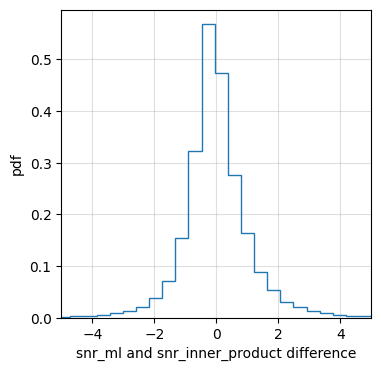

In [24]:
import matplotlib.pyplot as plt
y_pred = snrANN.flatten()
y_test = Y_
hist_ = y_pred-y_test
print(len(hist_))
idx = (y_test>4) & (y_test<100)
hist_ = hist_[idx]
#hist_ = hist_[abs(hist_)<5.]
print(len(hist_))
plt.figure(figsize=(4,4)) 
plt.hist(hist_, bins=100, histtype='step', density=True)
plt.xlim(-5,5)
plt.xlabel('snr_ml and snr_inner_product difference')
plt.ylabel('pdf')
plt.grid(alpha=0.4)
plt.show()

In [25]:
len1 = len(y_pred)
len2 = np.sum((y_pred>8) != (y_test>8))
error = len2/len1*100
print(f"Error: {error:.2f}%")

Error: 1.16%


In [29]:
from sklearn.metrics import confusion_matrix, accuracy_score
cm = confusion_matrix((y_test>8), (y_pred>8))
print(cm)
accuracy_score((y_test>8), (y_pred>8))

[[38192   399]
 [  498 38151]]


0.988386846193682